<a href="https://colab.research.google.com/github/neurorishika/PSST/blob/master/Tutorial/Day%202%20Let%20the%20Tensors%20Flow/Day%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%202%20Let%20the%20Tensors%20Flow/Day%202.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Day 2: Let the Tensors Flow!

Welcome to Day 2! Today, we start with our discussion with an introduction to TensorFlow followed by implementation of Numerical Integration techniques in TensorFlow.

### An Introduction to TensorFlow

TensorFlow is an open-source library that was developed by researchers and engineers in the Google Brain team. TensorFlow has a number of functions that make it particularly suitable for machine learning applications. However, it is primarily an interface for numerical computation. TensorFlow was designed with scalablity in mind. Code written using TensorFlow functions can work seamlessly on single cores, multi-core shared memory processors, high-performance computer clusters, and GPUs.

#### Why GPU vs CPU?

<img src="https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%202%20Let%20the%20Tensors%20Flow/GPUvsCPU.svg" width="600"/>

The answer lies in the architecture:  

ALUs (Arithmetic/Logical Units, i.e. CPU Cores/CUDA Cores) are the main circuits that perform all the computations. CPUs (left panel) have fewer ALUs than GPUs (right panel). But, at the same time, the CPU cores can run at a higher clock speed and can do more complex calculations. On the other hand, GPU cores are specialized for linear algebra especially vector operations. Furthermore, a single CPU processor has common memory and control units that must be refreshed every time a new thread of operations is executed. In contrast, GPUs have a hierarchical structure with multiple memory and control units, making them faster at executing multiple threads of operations. This makes GPUs better for simple but highly repetitive tasks executed in parallel, while the CPU is suitable for large complex computations executed serially.

In Summary,

**CPU = Faster per Core Processing, Slow but Large Memory Buffer, Few Cores**  
**GPU = Slower Processing, Faster but Smaller Memory Buffer, Many Cores**  

Thus GPUs are optimized for large number of simple calculations done in parallel. The extent of this parallelization makes it suitable for vector/tensor manipulation.

#### How TensorFlow works?

All computations in TensorFlow are specified as directed graphs (nodes connected by arrows) known as data flow graphs. Nodes are operations such as addition, multiplication etc. The incoming edges for each node are tensors (scalars, vectors, matrices and higher dimensional arrays), the actual values that are operated upon. The output is also a tensor that results from the computation. For example, consider the following computation where two vectors $a$ and $b$ serve as inputs to the node, a matrix multiplication operation, that produces a matrix $c$ as output.

<img src="https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%202%20Let%20the%20Tensors%20Flow/matmul.svg" width="300"/>

Here, "matmul" is a node which represents the matrix multiplication operation. a and b are input matrices (2-D tensors) and c is the resultant matrix.

#### Implementing a computational graph in TensorFlow

In [1]:
# First, import Numpy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow
# When using TensorFlow 2.x on both CPU only or single GPU setup, 
# we suggest using TensorFlow v1 Compatibility instead as follows:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# This is because of better multithreading optimization and disabled 
# eager execution in the earlier versions of TensorFlow which gives
# better performance. 

# Defining Input Matrices
a_ = [[1.],[2.],[3.]] # a 3x1 column matrix 
b_ = [[1.,2.,3.]] # a 1x3 row matrix 

# Creating nodes in the computation graph 
a = tf.constant(a_, dtype=tf.float64) # 3x1 tensor
b = tf.constant(b_, dtype=tf.float64) # 1x3 tensor
c = tf.matmul(a, b) 

# In TensorFlow v1.x compatible code, 
# To run the graph, we need to create a session.
# Creating the session initializes the computational device.

sess = tf.Session() # start a session
output = sess.run(c) # compute the value of c
sess.close() # end the session

print(output)

[[1. 2. 3.]
 [2. 4. 6.]
 [3. 6. 9.]]


#### Efficient recursion with TensorFlow

To iterate over a list in Python, we used a "for" loop. However, when we implement the same in TensorFlow, putting operations inside a loop replicates the defined computation and chains them together. This results in a long repetitive computation graph with the same operations chained one after the other, resulting in large memory usage and slow computation. TensorFlow provides an alternative with the tf.scan() method.

Say, one wants to recursively apply a function on an initial value but the function takes in additional input at every recursive call, for example, to find the cumulative sum over a list. Every step adds a new element from the list to the last addition. The TensorFlow function tf.scan allows us to easily implement such an iterator.

In [2]:
# define the recursive function that takes in two values the
# accumulated value and the additional input from a list.
def recursive_addition(accumulator,new_element):
    """
    This function takes in two values the accumulated value and the additional input which is added onto the accumulated value.
    """
    return accumulator+new_element

# define the list over which we iterate
elems = np.array([1, 2, 3, 4, 5, 6])

# tf.scan takes in three inputs: the recursive function, the 
# list to iterate over and the initial value. If an initial 
# value is not provided, its taken as the first element of elems.

# accumulate with no initializer
cum_sum_a = tf.scan(recursive_addition, elems) 
# accumulate with initializer as the number 5
cum_sum_b = tf.scan(recursive_addition, elems, tf.constant(5,dtype=tf.int64))

# To automatically close the session after computation in TensorFlow 1.13, Use:
# with tf.Session() as sess:
#    output = sess.run(c) 
with tf.Session() as sess:
    output_a = sess.run(cum_sum_a)
    output_b = sess.run(cum_sum_b)

print(output_a)
print(output_b)

[ 1  3  6 10 15 21]
[ 6  8 11 15 20 26]


As an **Exercise** use tf.scan to compute the fibonacci sequence.

#### Euler Integration Function in TensorFlow
We now implement Euler's method using tf.scan to iterate over the time array. Note that the function scan\_func that defines each step of Euler's method, is now an input to tf.scan.

In [3]:
def tf_check_type(t, y0): # Ensure Input is Correct
    """
    This function checks the type of the input to ensure that it is a floating point number.
    """
    if not (y0.dtype.is_floating and t.dtype.is_floating): 
        # The datatype of any tensor t is accessed by t.dtype
        raise TypeError('Error: y0 and t must be floating point numbers')

class _Tf_Integrator():
    """
    A class for integrating a function using the Euler method in TensorFlow.
    """
    def integrate(self, func, y0, t): 
        """
        This function integrates a function func using the Euler method in TensorFlow.
        
        Parameters:
        -----------
        func: function
            The function to be integrated.
        y0: float
            The initial condition.
        t: numpy array
            The time array.
        """
        time_delta_grid = t[1:] - t[:-1]  # define the time step at each point
        
        def scan_func(y, t_dt):  # define the scan function that performs the integration step
            """
            This function performs the integration step.

            Parameters:
            -----------
            y: float
                The value of y at which the function is being evaluated.
            t_dt: (float, float)
                The time point and time step at which the function is being evaluated.
            """
            t, dt = t_dt # unpack the time point and time step
            dy = dt*func(y,t) # compute the change in function at the current time point
            return y + dy # return the new value of y
        
        # iterating over (a,b) where a and b are lists of same size
        # results in the ith accumulative step in tf.scan receiving
        # the ith elements of a and b zipped together
        
        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0) # perform the integration using tf.scan
        return tf.concat([[y0], y], axis=0) # add the initial condition at the beginning and return the values

def tf_odeint_euler(func, y0, t):
    """
    This function integrates the function func using the Euler method implemented in the _Tf_Integrator class.

    Parameters:
    -----------
    func: function
        The function to be integrated.
    y0: float
        The initial condition.
    t: numpy array
        The time array.
    """
    # Ensure Input is in the form of TensorFlow Tensors
    t = tf.convert_to_tensor(t, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t) # Ensure Input is of the correct type
    return _Tf_Integrator().integrate(func,y0,t)

#### Running the TensorFlow Euler Integrator

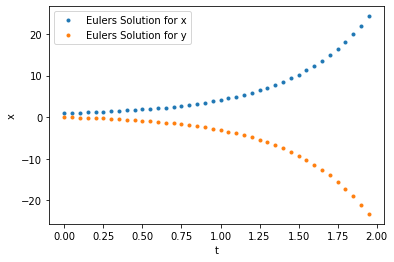

In [4]:
# Define a function using Tensorflow math operations. This creates a computational graph.

def f(X,t):
    # extracting a single value eg. X[0] returns a single value but
    # we require a tensor, so we extract a range with one element.
    x = X[0:1] 
    y = X[1:2]
    out = tf.concat([x-y,y-x],0)
    return out

y0 = tf.constant([1,0], dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,2,epsilon)

# Define the final value (output of scan) that we wish to compute as a variable

state = tf_odeint_euler(f,y0,t)

# Start a TF session and evaluate state
with tf.Session() as sess:
    state = sess.run(state)

# Plot the solution
plt.plot(t[::5],state.T[0,::5],".",label="Eulers Solution for x")
plt.plot(t[::5],state.T[1,::5],".",label="Eulers Solution for y")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

#### RK4 Integration Function in TensorFlow

Now, we implement the RK4 integrator in TensorFlow. Note that here we replace the single step iterator used for the Euler's with a four step RK4 iterator. In addition, to make the code more modular, we define a function \_step\_func() that is called by scan\_func and calculates the next step of the RK4 integrator. The rest of the program remains the same as the Euler's method implemented above.

In [5]:
def tf_check_type(t, y0): # Ensure Input is Correct
    """
    This function checks the type of the input to ensure that it is a floating point number.
    """
    if not (y0.dtype.is_floating and t.dtype.is_floating):
        raise TypeError('Error: y0 and t must be floating point numbers')

class _Tf_Integrator():
    """
    This class implements the Runge-Kutta 4th order method in TensorFlow.
    """
    def integrate(self, func, y0, t):
        """
        This function integrates a function func using the Runge-Kutta 4th order method in TensorFlow.

        Parameters:
        -----------
        func: function
            The function to be integrated.
        y0: float
            The initial condition.
        t: numpy array
            The time array.
        """
        time_delta_grid = t[1:] - t[:-1] # define the time step at each point
        
        def scan_func(y, t_dt): # define the scan function that performs the integration step
            """
            This function performs the integration step.
            
            Parameters:
            -----------
            y: float
                The value of y at which the function is being evaluated.
            t_dt: (float, float)
                The time point and time step at which the function is being evaluated.
            """
            t, dt = t_dt # unpack the time point and time step
            dy = self._step_func(func,t,dt,y) # Make code more modular.
            return y + dy

        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0)
        return tf.concat([[y0], y], axis=0)
    
    def _step_func(self, func, t, dt, y):
        """
        This function determines the value of the integration step.

        Parameters:
        -----------
        func: function
            The function to be integrated.
        t: float
            The time point at which the function is being evaluated.
        dt: float
            The time step at which the function is being integrated.
        y: float
            The value of y at which the function is being evaluated.
        """
        k1 = func(y, t)
        half_step = t + dt / 2
        dt_cast = tf.cast(dt, y.dtype) # Failsafe

        k2 = func(y + dt_cast * k1 / 2, half_step)
        k3 = func(y + dt_cast * k2 / 2, half_step)
        k4 = func(y + dt_cast * k3, t + dt)
        return tf.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6) # add all update terms
    
def tf_odeint_rk4(func, y0, t):
    """
    This function integrates the function func using the Runge-Kutta 4th order method implemented in the _Tf_Integrator class.

    Parameters:
    -----------
    func: function
        The function to be integrated.
    y0: float
        The initial condition.
    t: numpy array
        The time array.
    """
    # Ensure Input is in the form of TensorFlow Tensors
    t = tf.convert_to_tensor(t, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t) # Ensure Input is of the correct type
    return _Tf_Integrator().integrate(func,y0,t)

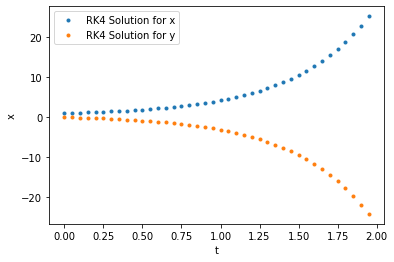

In [6]:
# Define a function using Tensorflow math operations. This creates a computational graph.

def f(X,t):
    # extracting a single value eg. X[0] returns a single value but
    # we require a tensor, so we extract a range with one element.
    x = X[0:1] 
    y = X[1:2]
    out = tf.concat([x-y,y-x],0)
    return out

y0 = tf.constant([1,0], dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,2,epsilon)

# Define the final value (output of scan) that we wish to compute as a variable

state = tf_odeint_rk4(f,y0,t)

# Start a TF session and evaluate state
with tf.Session() as sess:
    state = sess.run(state)

# Plot the solution
plt.plot(t[::5],state.T[0,::5],".",label="RK4 Solution for x")
plt.plot(t[::5],state.T[1,::5],".",label="RK4 Solution for y")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

**Exercise** Simulate the non-linear Lorentz Attractor using Euler Method and RK4 on TensorFlow which is given by the equations:

$$\frac{dx}{dt}=\sigma(y-x)$$

$$\frac{dy}{dt}=x(\rho-z)-y$$

$$\frac{dz}{dt}=xy-\beta z$$

Use the values $\sigma =10$, $\beta =\frac{8}{3}$, $\rho =28$. You can try simulating this system at two nearby starting conditions and comment on the difference.

<img src="https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%202%20Let%20the%20Tensors%20Flow/lorenz.svg" width="400"/>

In [7]:
#####################################
# Problem Hint for the Euler Method #
#####################################

# # Note: Uncommment and complete the code below to practice the Euler method to simulate a lorenz attractor.

# epsilon  = ... # define the resolution of the simulation
# t = ... # define the time array

# sigma = ... # define the sigma parameter
# beta = ... # define the beta parameter
# rho = ... # define the rho parameter

# def F(X,t): # Create a new function F(X,t) where X is a vector of the form [theta,omega] and t is the time. 
#     """
#     This function defines the differential equation for the lorenz attractor.

#     Parameters:
#     -----------
#     X: numpy array
#         The state vector of the lorenz attractor given by [x,y,z].
#     t: float
#         The time.
#     """
#     x = ... # extract the x variable from the state vector
#     y = ... # extract the y variable from the state vector
#     z = ... # extract the z variable from the state vector
#     dx = ... # define the derivative of x
#     dy = ... # define the derivative of y
#     dz = ... # define the derivative of z
#     return np.array([dx,dy,dz]) # return the derivative of the state vector

# solution = tf_odeint_euler(...) # Use the Euler method to solve the pendulum problem

# # Plot the solution in 3D
# from mpl_toolkits import mplot3d

# ax = plt.axes(projection='3d')
# ax.plot3D(solution[0,:],solution[1,:],solution[2,:],label="Euler Solution for x,y,z in 3D")
# plt.xlabel("t")
# plt.ylabel("theta/omega")
# plt.legend()
# plt.show()

# # Now try to implement the Runge-Kutta of order 4 method to solve the same problem.

### Additional Information about Computational Hardware:

#### About TPU (Tensor Processing Units):
In recent years, there have been a lot of advancements in the hardware available for large-scale computing. In 2016, Google announced a new hardware architecture known as TPUs (Tensor Processing Units) that were specifically designed for use with the TensorFlow library. TPUs utilize a specialized Matrix Multiplication Unit that maximizes parallel computation and are capable of much faster matrix multiplication than CPUs or GPUs. As a result, TPUs can further speed up the the integration of ODEs and other numerical simulations. While, the code we presented in this tutorial can be run on a system with available TPUs, the allocation of tasks to different TPU cores is not currently automated and must be done manually. And so, using TPUs efficiently may require a few additional steps which are outside the scope of this tutorial. However, as TPUs are becoming more popular, it is likely that future versions of the TensorFlow library will be able to automatically allocate tasks to different TPU cores.